<a href="https://colab.research.google.com/github/isaachfp/bi-master/blob/master/Conf_Dados/20210112_Ex1/Anomalia_Supervisionado%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Em* Detecção de anomalias *, aprendemos que, se houver dados de treinamento disponíveis, a detecção supervisionada de anomalias pode ser usada, o que converte o problema de detecção de anomalias em um problema de classificação, embora com desafios especiais. Na palestra, focamos em um desafio comum: o desequilíbrio de classe, que surge porque as anomalias são raras (por definição).

Aqui, serão detectadas anomalias nos conjuntos de dados simulados, usando métodos de aprendizado sensíveis a custos, reamostragem adaptativa e aumento.


# Importações

Este notebook usa dois pacotes que podem exigir instalação:

1. Mlxtend (extensões de aprendizado de máquina), que é uma biblioteca Python de ferramentas úteis para tarefas de ciência de dados.
(http://rasbt.github.io/mlxtend/)


2. desbalance-learn, que é um pacote Python que oferece técnicas de reamostragem comumente usadas em conjuntos de dados mostrando forte desequilíbrio de classe
(https://imbalanced-learn.org/en/stable/index.html)

As instruções de instalação estão abaixo.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from collections import Counter
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# Python and library versions

In [2]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0] 

library    version
------------------
matplotlib  3.2.2
numpy       1.19.5
pandas      1.1.5


# Seção 1: Aprendizagem Sensível aos Custos

Nesta seção, usaremos dados simulados para examinar o aprendizado sensível aos custos. Nossa detecção supervisionada de anomalias será feita usando um classificador de árvore de decisão (https://scikit-learn.org/stable/modules/tree.html#tree).

Procederemos da seguinte forma:

1. Crie os dados simulados
2. Treine nosso algoritmo, dando a todos os pontos de dados o mesmo peso
3. Examine as classificações incorretas usando uma matriz de confusão
4. Repita as etapas (2) e (3) usando aprendizado sensível ao custo e compare nossos resultados.
# Resultados de Aprendizagem

Você deve sair deste tutorial em Python com:

1. Compreensão da detecção supervisionada de anomalias
2. Alguma experiência prática com aprendizado sensível a custos, reamostragem adaptativa e métodos de reforço.

### Data

Criamos os dados sintéticos usando a função * make_classification * do sklean. Criamos 5000 pontos com aproximadamente 90% de pontos normais (etiqueta 0) e 10% de anomalias (etiqueta 1).

In [19]:
# Generate synthetic imbalanced data 
features, label = make_classification(n_samples=5000, n_features=2, 
                                      n_informative=2, n_redundant=0, 
                                      n_repeated=0, n_classes=2, 
                                      n_clusters_per_class=1,
                                      weights=[0.90, 0.10], flip_y=0.01,
                                      class_sep=1.5, random_state=42)


Para obter uma explicação detalhada dos parâmetros * make_classification *, consulte https://scikitlearn.org/stable/modules/generated/sklearn.datasets.make_classification.html.

Aqui discutimos alguns deles.

Especificamos que os pesos iniciais da classe normal e de anomalia sejam 0,90 e 0,10, respectivamente, usando * pesos *.

Com * flip_y *, especificamos a fração de amostras cuja classe é trocada aleatoriamente para introduzir algum ruído nos dados.

E usamos * class_sep * para especificar a separação entre as duas classes; valores maiores espalham as classes.

In [20]:
df = pd.DataFrame(features, columns=['feature1', 'feature2'])
df['label'] = label

In [21]:
df.head()

,feature1,feature2,label
0,0.083748,-1.924311,0
1,3.161682,-2.016850,0
2,0.601813,-0.447617,0
3,0.379934,-1.622870,0
4,0.246233,-2.249783,0


Plote os dados e o código de cores normal versus anomalia. Aqui usamos * lmplot * de * seaborn *, pois oferece uma maneira compacta de rotular pontos por classe.

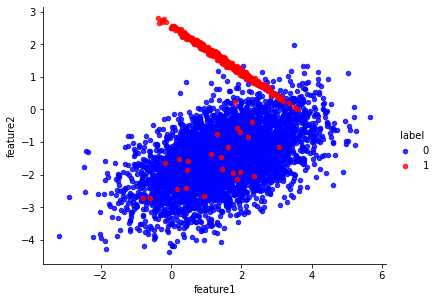

In [22]:
colors = ['blue', 'red']
sns.lmplot('feature1', 'feature2', data=df, hue='label',
           palette=colors, fit_reg=False, scatter_kws={'s': 20})
plt.gcf().set_size_inches(6,4);

Agora, treinamos nosso classificador. Usaremos uma árvore de decisão com uma única divisão (geralmente chamada de tronco de decisão). Esta árvore toma uma decisão com base em um único recurso de entrada.

In [23]:
# Plain tree as 
tree_plain = DecisionTreeClassifier(max_depth=1, class_weight=None)

Usaremos * plot_decision_regions * de * mlxtend * para mostrar as regiões que o classfier usa para atribuir rótulos de classe.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


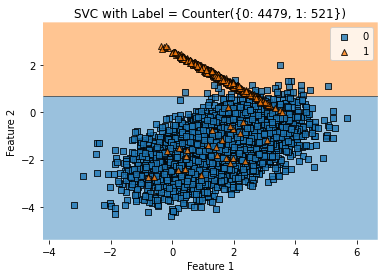

In [24]:
tree_plain_fit = tree_plain.fit(features, label)
plot_decision_regions(features, label, tree_plain_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Como esperado, as duas classes são separadas por uma única linha, pois apenas um recurso foi usado para a divisão.

Em seguida, examinamos as estatísticas da classificação.

In [25]:
cm_tree_plain=confusion_matrix(label, tree_plain.predict(features))
print(cm_tree_plain)
accuracy_tree_plain = accuracy_score(label, tree_plain.predict(features))
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


Classificamos incorretamente 37 pontos normais e 47 anomalias. Nada mal, mas vamos tentar melhorar esse resultado.

Para isso, apresentaremos um aprendizado sensível aos custos. Para nossa árvore de decisão, o aprendizado sensível ao custo pode ser introduzido através do parâmetro * class_weight *. Na análise anterior, este parâmetro foi definido como * Nenhum *, o que significa que todos os pontos receberam peso igual.

Em nossa próxima iteração, definiremos * class_weight * como * equilibrado *. Nesse caso, os pesos são ajustados inversamente proporcionais à frequência da classe. Ou seja, o custo de cometer um erro é inversamente proporcional ao número de instâncias dessa classe, que é o exemplo que discutimos na palestra.

Para mais detalhes, consulte https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


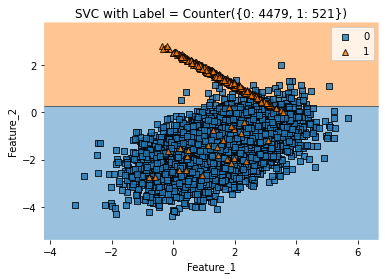

In [26]:
tree_bal = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
tree_bal_fit = tree_bal.fit(features, label)
plot_decision_regions(features, label, tree_bal_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Observe que o limite foi movido. Agora está mais perto de Feature_2 = 0. Isso é promissor. Isso mostra que a aprendizagem sensível aos custos teve um efeito na classificação. É para melhor?

In [27]:
cm_tree_bal=confusion_matrix(label, tree_bal.predict(features))
print(cm_tree_bal)
accuracy_tree_bal = accuracy_score(label, tree_bal.predict(features))
print(f'Accuracy: {accuracy_tree_bal}')

[[4381   98]
 [  27  494]]
Accuracy: 0.975


A precisão caiu e classificamos erroneamente mais pontos normais (98 vs. 37 anteriormente).

No entanto, melhoramos nossa classificação de anomalias. Apenas 27 foram classificados incorretamente (vs. 47 antes). Se o que mais importa para nós são as anomalias, a menor taxa de classificação incorreta é uma melhoria significativa.

O aprendizado sensível aos custos está fazendo o que deve: ajudar a detectar anomalias.

# Seção 2: Reamostragem adaptativa

Nesta seção, usaremos os dados da seção anterior para ilustrar a reamostragem adaptativa. Nossa detecção supervisionada de anomalias será feita usando a classificação do vetor de suporte - SVC (https://scikit-learn.org/stable/modules/svm.html#svm-classification).


Vamos proceder como fizemos antes:

1. Treine nosso algoritmo de detecção de anomalias sem nenhuma reamostragem
2. Calcular o custo de nossa classificação incorreta
3. Repita as etapas (2) e (3) usando reamostragem adaptativa e compare nossos resultados.

Primeiro, criamos nosso classificador usando o conjunto de dados de treinamento.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


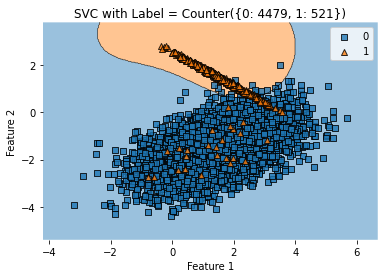

In [28]:
clf = SVC().fit(features, label)
plot_decision_regions(features, label, clf)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Vemos (a partir do título da trama) que temos 521 anomalias e 4479 pontos normais. Ou seja, 10,4% dos pontos são anomalias.

Vejamos a matriz de confusão para ver como nosso classificador funciona.

In [29]:
cm=confusion_matrix(label, clf.predict(features))
print(cm)

[[4457   22]
 [  47  474]]


Para tornar as coisas mais claras, imprimimos cada categoria.

In [30]:
tn, fp, fn, tp = cm.ravel()
print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')
accuracy = accuracy_score(label, clf.predict(features))
print(f'Accuracy: {accuracy}')

True Negative: 4457
False Positive: 22
False Negative: 47
True Positive: 474
Accuracy: 0.9862


Em outras palavras, classificamos incorretamente 18 pontos normais e 40 anomalias. Podemos fazer melhor?

### Sobre-amostragem

Como primeira tentativa de melhorar, vamos exagerar a classe de anomalia. Usaremos * RandomOverSampler * de * imblearn * para criar um conjunto de dados de treinamento reamostrado.

Insumos essenciais: quanto queremos exagerar na classe de anomalia. Aqui vamos especificar a superamostra como uma fração do tamanho da classe normal. Essa fração * resample_ratio * deve atender a duas condições:

1. Deve ser menor ou igual a 1, para que a classe de anomalia permaneça sempre uma minoria.

2. A fração deve ser grande o suficiente para que o número de pontos de anomalia no conjunto de dados reamostrado seja maior que o número no conjunto de dados original. Caso contrário, iremos subamostrar a classe de anomalia.

A violação de qualquer condição produz um aviso.

In [42]:
# Random oversampling of the anomaly class
resample_ratio = 0.8 # (anomalies / normal) after resampling
sample_normal = tn + fp # total number of true normal points
sample_anomaly = int(resample_ratio*sample_normal) # must be an integer
sampling_dict = {0: sample_normal, 1: sample_anomaly}
ros = RandomOverSampler(ratio=sampling_dict, random_state=0) 
features_resampled, label_resampled = ros.fit_sample(features,label)

Mostrar quantos pontos em cada classe após a reamostragem

In [43]:
Counter(label_resampled)

Counter({0: 4479, 1: 3583})

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


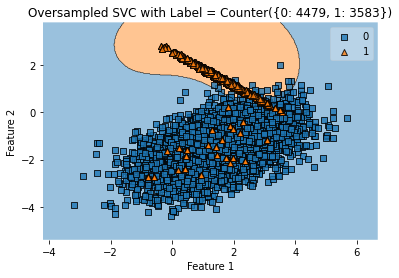

In [44]:
clf_ros = SVC().fit(features_resampled, label_resampled)
plot_decision_regions(features_resampled, label_resampled, clf_ros)
plt.title(f'Oversampled SVC with Label = {Counter(label_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(6,4)

Como antes, mostramos a matriz de confusão e categorias individuais para nossas previsões.

In [45]:
cm_ros = confusion_matrix(label, clf_ros.predict(features))
cm_ros

array([[4428,   51],
       [  28,  493]])

In [46]:
tn_ros, fp_ros, fn_ros, tp_ros = cm_ros.ravel()
print('After Random Oversampling')
print(f'True Negative: {tn_ros}')
print(f'False Positive: {fp_ros}')
print(f'False Negative: {fn_ros}')
print(f'True Positive: {tp_ros}')
accuracy_ros = accuracy_score(label, clf_ros.predict(features))
print(f'Accuracy: {accuracy}')

After Random Oversampling
True Negative: 4428
False Positive: 51
False Negative: 28
True Positive: 493
Accuracy: 0.9862


Agora classificaram 28 pontos normais e 34 anomalias.

Anteriormente, classificamos incorretamente 18 pontos normais e 40 anomalias.

Qual é melhor?

A resposta depende do custo da classificação incorreta.

Vamos definir uma função que calcula esse custo. Na função abaixo, assumimos implicitamente que um ponto classificado corretamente não tem custo.

In [47]:
def misclass_cost(false_pos, false_neg, false_pos_cost, false_neg_cost):
    '''
    Calculates the cost of misclassified instances
   
    Args: 
        false_pos: number of false positives (float)
        false_neg: number of false negatives (float)
        false_pos_cost: cost of a false positive (float > 0)
        false_neg_cost: cost of a false negative (float > 0)
        
    Returns: 
        misclass_cost: the cost of misclassifcation (float)
        
    Raises:
        Error: if false_pos_cost or false_neg_cost are non-positive
    '''
    if(false_pos_cost <= 0  or false_neg_cost <= 0):
        print('Costs must be greater than zero')
        return
    else:
        misclass_cost = (false_pos*false_pos_cost 
                         + false_neg*false_neg_cost)
        return misclass_cost

Now to assign costs. We will follow the approach described in the lecture for the screening test, where the cost for a false negative is greater than for a false positive. 

In [48]:
false_pos_cost = 10
false_neg_cost = 100

Finalmente, podemos calcular o custo a partir do conjunto de dados regular e do sobre-amostrado aleatoriamente.

In [49]:
cost_reg = misclass_cost(fp, fn, false_pos_cost, false_neg_cost)
cost_ros = misclass_cost(fp_ros, fn_ros, false_pos_cost, false_neg_cost)
print(f'Without oversampling the cost is: {cost_reg}')
print(f'With random oversampling the cost is: {cost_ros}')
print('')
print(f'Accuracy without oversampling is: {accuracy}')
print(f'Accuracy with random oversampling is: {accuracy_ros}')

Without oversampling the cost is: 4920
With random oversampling the cost is: 3310

Accuracy without oversampling is: 0.9862
Accuracy with random oversampling is: 0.9842


A amostragem aleatória reduziu o custo da classificação incorreta, apesar da menor precisão.

** Pergunta **: O que acontece se os custos de falso positivo e falso negativo forem iguais?

** Resposta **: o custo será proporcional a (1 precisão). Em outras palavras, usar a precisão como métrica equivale a assumir custos iguais para as duas categorias.

### Subamostragem

Vamos ver como a subamostragem faz. A estrutura desta seção é a mesma da superamostragem, exceto que agora subamostramos a classe normal.

Como antes, temos uma entrada essencial: quanto queremos subamostrar a classe normal. Aqui, especificaremos a subamostragem como um múltiplo do tamanho da classe de anomalia. Esse múltiplo, * resample_ratio_under *, deve atender a duas condições:

1. Deve ser maior ou igual a 1, para que a classe normal permaneça sempre majoritária.

2. O múltiplo deve ser pequeno o suficiente para que o número de pontos normais no conjunto de dados reamostrado seja menor que o número no conjunto de dados original. Caso contrário, estaremos superamostrando a classe normal.

In [50]:
# Random undersampling of the normal class

# resample_ratio_under is (normal/anomalies) after resampling
# Should be int, but added int() later to prevent error
resample_ratio_under = 1 # a 1:1 ratio is a typical starting point

sample_anomaly_under = tp + fn 

# total number of true normal points
# int is a safeguard in case resample_ratio_under is given as float
sample_normal_under = int(resample_ratio_under*sample_anomaly_under)

sampling_dict = {0: sample_normal_under, 1: sample_anomaly_under}
rus = RandomUnderSampler(ratio=sampling_dict, random_state=0) 
features_resampled_2, label_resampled_2 = rus.fit_sample(features,label)

In [51]:
# Check undersampling 
Counter(label_resampled_2)

Counter({0: 521, 1: 521})

Para simplificar, omita a plotagem e apenas calcula as estatísticas

In [52]:
clf_rus = SVC().fit(features_resampled_2, label_resampled_2)

In [53]:
cm_rus = confusion_matrix(label, clf_rus.predict(features))
print(cm_rus)
accuracy_rus = accuracy_score(label, clf_rus.predict(features))
tn_rus, fp_rus, fn_rus, tp_rus = cm_rus.ravel()
cost_rus = misclass_cost(fp_rus, fn_rus, false_pos_cost, false_neg_cost)
print('')
print(f'With random undersampling the cost is: {cost_rus}')
print(f'Accuracy with random undersampling is: {accuracy_rus}')

[[4388   91]
 [  27  494]]

With random undersampling the cost is: 3610
Accuracy with random undersampling is: 0.9764


A subamostragem é ainda melhor do que a superamostragem em termos de custo, apesar da queda adicional na precisão.

# Seção 3 AdaBoost


Nesta seção, examinaremos os métodos de reforço. Mais especificamente, veremos o aumento adaptativo (AdaBoost).

Como discutimos na palestra, o AdaBoost funciona bem com qualquer aluno fraco, mas é mais comumente usado com árvores de decisão. Portanto, nesta seção, aplicaremos a árvore simples da Seção 1 (onde * class_weight * é * None *) e veremos se isso melhora nossos resultados.

In [54]:
bdtree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, 
                                                   class_weight=None),
                            n_estimators=100)

O AdaBoost apresenta paramaters extras que devem ser especificados. O único parâmetro que mudaremos do valor padrão é * n_estimators *, que é o número máximo de estimadores nos quais o aumento é finalizado.

Uma lista completa de parâmetros está aqui: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


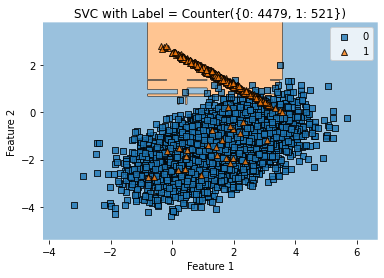

In [55]:
bdtree_fit = bdtree.fit(features, label)
plot_decision_regions(features, label, bdtree_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

O AdaBoost criou um limite de decisão mais complexo. Não é mais uma única linha reta. As estatísticas também melhoraram?

In [56]:
cm_bdtree=confusion_matrix(label, bdtree.predict(features))
print(cm_bdtree)
accuracy_bdtree = accuracy_score(label, bdtree.predict(features))
print(f'Accuracy: {accuracy_bdtree}')

[[4460   19]
 [  43  478]]
Accuracy: 0.9876


Recupere os resultados sem aumentar

In [57]:
print(cm_tree_plain)
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


Impulsionar aumentou a precisão e até melhorou um pouco o número de anomalias detectadas corretamente (478 vs. 474) Útil!